In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm 
import random as rd
import itertools
from scipy.stats import qmc, ttest_ind, bartlett
import pickle


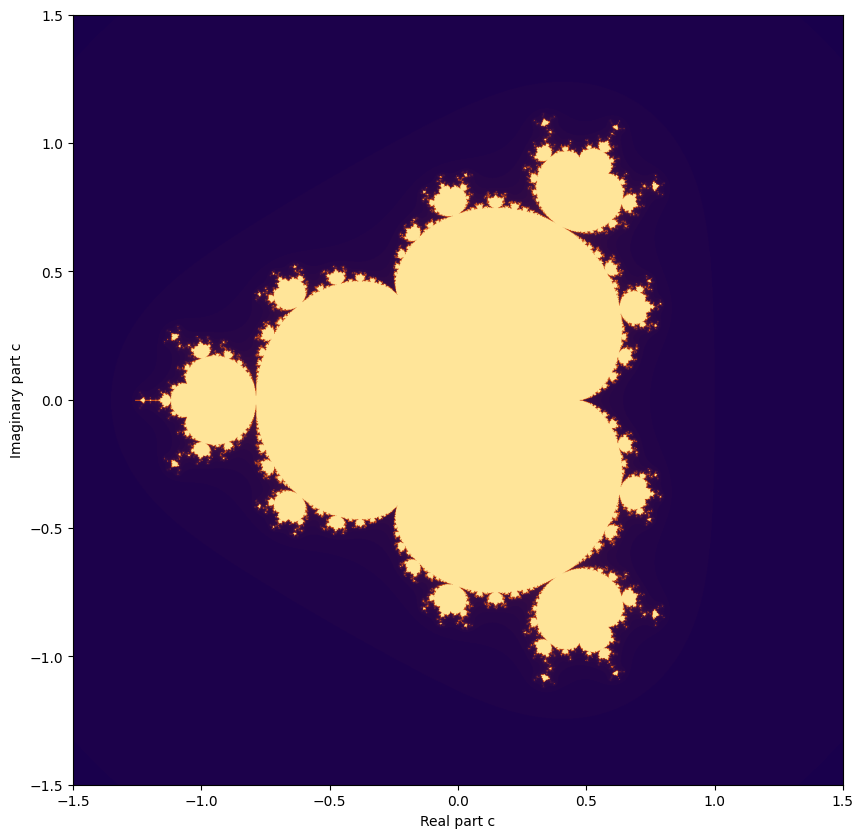

In [ ]:
# set graph size and axes 
width, height = 1500, 1500
x_min, x_max = -1.5, 1.5 # used -1.5, 1.5 for plots
y_min, y_max = -1.5, 1.5 # used -1.5, 1.5 for plots

# custom coloring 
colors = [(0.1, 0, 0.3), (0.8, 0.3, 0.1), (1, 0.9, 0.6)]    
name = "nicemap"
cmap = LinearSegmentedColormap.from_list(name, colors)

# max iterations we test for to let it escape, increase for more detail
max_iterations = 100

# empty set to store iteration counts
mandelbrot_set = np.zeros((height, width))

# Iterate over each pixel in the image
for i in range(width):
    for pixel in range(height):
        # position to complex number. complex(computes real part, computes imaginary part) 
        c = complex(x_min + (i / width) * (x_max - x_min),
                    y_min + (pixel / height) * (y_max - y_min))
        # set z at time 0 = 0 
        z = 0 
        # keep count of iterations
        iteration = 0
        
        # mandelbrot where we set a threshold that is equal to 2 and apply formula
        # change **d for m2 m3 and m4
        while abs(z) <= 2 and iteration < max_iterations:
            z = z**2 + c 
            iteration += 1
            
        # store iterations
        mandelbrot_set[pixel, i] = iteration

# plot
plt.figure(figsize=(12,10))
plt.imshow(mandelbrot_set, cmap, extent=(x_min, x_max, y_min, y_max))
plt.xlabel("Real part c")
plt.ylabel("Imaginary part c")
plt.savefig("mandelbrotM2", dpi = 300)
plt.show()


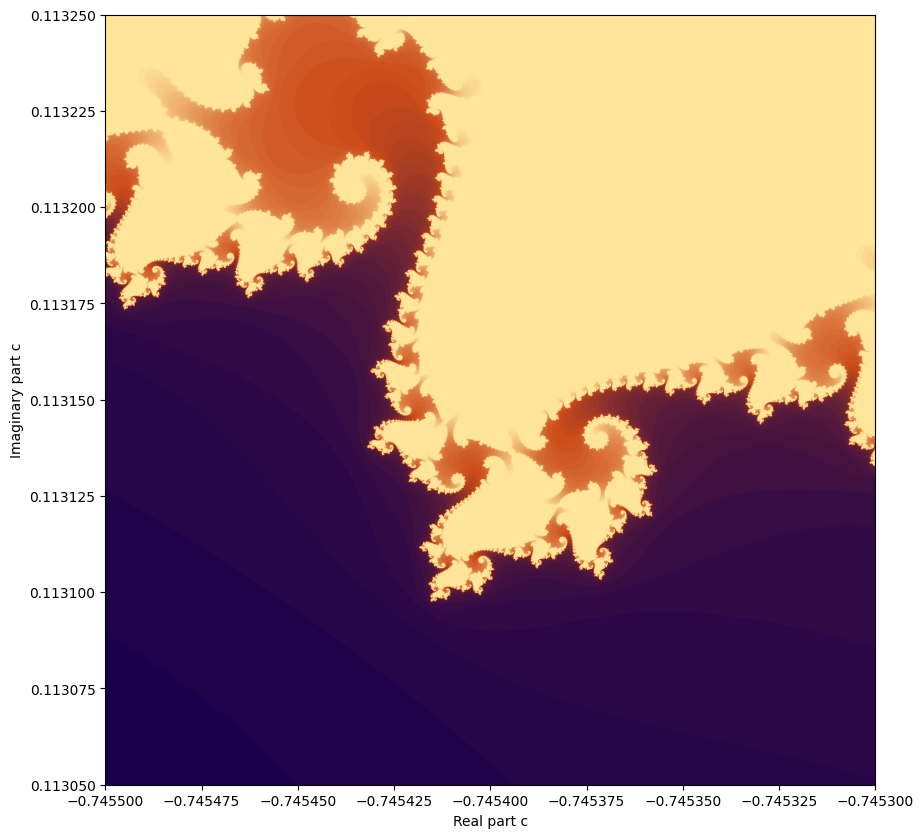

In [25]:
# set graph size and axes
width, height = 2000, 2000
# zoom 1
x_min, x_max = -1.405, -1.395
y_min, y_max = -0.005, 0.005
# zoom2
#x_min, x_max = -0.7455, -0.7453
#y_min, y_max = 0.11305, 0.11325

# custom coloring 
colors = [(0.1, 0, 0.3), (0.8, 0.3, 0.1), (1, 0.9, 0.6)]    
name = "nicemap"
cmap = LinearSegmentedColormap.from_list(name, colors)

# max iterations we test for to let it escape, increase for more detail
max_iterations = 100

# empty set to store iteration counts
mandelbrot_set = np.zeros((height, width))

# iterate over each pixel in the image
for i in range(width):
    for pixel in range(height):
        # position to complex number. complex(computes real part, computes imaginary part) 
        c = complex(x_min + (i / width) * (x_max - x_min),
                    y_min + (pixel / height) * (y_max - y_min))
        # set z at time 0 = 0 
        z = 0 
        # keep count of iterations
        iteration = 0
        
        # mandelbrot where we set a threshold that is equal to 2 and apply formula
        while abs(z) <= 2 and iteration < max_iterations:
            z = z**2 + c 
            iteration += 1
            
        # store iterations
        mandelbrot_set[pixel, i] = iteration

# plot
plt.figure(figsize=(12,10))
plt.imshow(mandelbrot_set, cmap, extent=(x_min, x_max, y_min, y_max))
# plt.colorbar(label="iterations")
plt.xlabel("Real part c")
plt.ylabel("Imaginary part c")
plt.savefig("Zoom1_Mandel1", dpi = 300)
plt.show()


### QUESTION 2 & 3

In [9]:
def monte_carlo(n_samples, sample_type,  n_iterations, y_min, y_max, x_min, x_max): 
    """
    Monte carlo integration with three sampling methods
    1. Pure random sampling
    2. Latin hypercube sampling
    3. Orthogonal sampling
    """
    true_count = 0      

    if sample_type == "lhs": 
        points = lhs_qmc(n_samples, y_min, y_max, x_min, x_max)
    elif sample_type == "orthogonal":
        points = orthogonal_sample(n_samples, x_min, x_max, y_min, y_max)
    elif sample_type == "pure_random": 
        points = pure_radom_sample(y_min, y_max, x_min, x_max, n_samples)


    for i in range(len(points)): 
        x_coordinate, y_coordinate, complex_element = points[i][0], points[i][1], points[i][2]
        if mandel_check(complex_element, n_iterations):
            true_count +=1 

    area_total = (x_max-x_min)*(y_max-y_min)
    mandel_area = (true_count/(n_samples)) * area_total
    print(f"Estimated area for {n_samples} samples and {n_iterations} iterations: {mandel_area}")
    return mandel_area

def mandel_check(complex_number, max_iteration): 
    """
    Check if point belongs to Mandelbrot set or not
    """
    z = 0
    for _ in range(max_iteration): 
        z = z**2 + complex_number
        if abs(z) > 2: 
            return False
    return True

def pure_radom_sample(y_min, y_max, x_min, x_max, n_samples):
    """
    Pure random sampling
    """
    samples = [] 
    for _ in range(n_samples): 
        x_coordinate = rd.uniform(x_min, x_max)
        y_coordinate  = rd.uniform(y_min, y_max)
        complex_element = complex(x_coordinate,y_coordinate)
        samples.append([x_coordinate, y_coordinate, complex_element])

    return samples


def lhs_qmc(n_samples, y_min, y_max, x_min, x_max):
    """
    Latin hypercube sampling
    """
    sampler = qmc.LatinHypercube(d=2)  

    # generate  samples
    lhs_samples = sampler.random(n=n_samples)

    # Rescale 
    x_coordinates_rescaled = x_min + (x_max - x_min) * lhs_samples[:, 0]
    y_coordinates_rescaled = y_min + (y_max - y_min) * lhs_samples[:, 1]
    complex_elements = x_coordinates_rescaled + 1j * y_coordinates_rescaled

    # Combine
    samples = np.column_stack((x_coordinates_rescaled, y_coordinates_rescaled, complex_elements)).tolist()
    
    return samples
 

def orthogonal_sample(n_samples, x_min, x_max, y_min, y_max): 
    """
    Orthogonal sampling
    """
    blocks = int(np.sqrt(n_samples))
    samples = [] 


    # create two squares
    xlist = np.arange(0,blocks*blocks,dtype=int).reshape(blocks,blocks)
    ylist = np.arange(0,blocks*blocks,dtype=int).reshape(blocks,blocks)

    # np.random.shuffle(xlist)
    # np.random.shuffle(ylist)

    for i in range(len(xlist)):
        np.random.shuffle(xlist[i])
        np.random.shuffle(ylist[i])
    
    # scale and create random
    for i in range(blocks):
        for j in range(blocks):
            x_coordinate = x_min + ((x_max-x_min) / n_samples) * ( xlist[i][j] + np.random.random())
            y_coordinate = y_min + ((y_max-y_min) / n_samples) * ( ylist[j][i] + np.random.random())
            complex_element = complex(x_coordinate, y_coordinate)
            samples.append([x_coordinate, y_coordinate, complex_element])

    return samples

In [ ]:
"""
Initialize hyperparameters for running simulation

*Notes: 
- this code needs to be ran in order for plots to work
- this code neds to be runned for simulations to work
"""

# set sampling algorithm
sample_types = ["pure_random", "lhs", "orthogonal"]  # alternitive: "pure_random", "orthogonal" 
# set number of iterations
n_it = [100,250,500]
# set sample size
n_samples = [900, 8100, 22500, 44100, 72900, 108900, 129600, 152100, 176400, 202500, 230400, 260100,291600, 324900, 360000, 396900, 435600, 476100, 525625, 562500, 656100, 756900]

# Variables Am 
Am_samples = 1000000 
Am_iterations = 1000 




for n in n_samples:
    if not np.sqrt(n).is_integer():
        raise ValueError (f"{n}")


# complex plain boundaries: y_min, y_max
x_min, x_max = -2, 2
y_min, y_max = -2, 2

Running Am

In [ ]:
"""
Main run

Results are stored in results_2_3_ and can be retrieved in the next block of code

Warning: running time can be long
"""

sample_types = ["pure_random", "orthogonal", "lhs"]  # alternitive: "pure_random", "orthogonal" 

# loop over all sample types
for sample_type in sample_types:
      with open(f"results_2_3_/{sample_type}_Am.pkl", "wb") as f:
            results = [monte_carlo(Am_samples, sample_type, Am_iterations, y_min, y_max, x_min, x_max) for _ in tqdm(range(50), desc=f"Results for Am {sample_type}", ncols=100)]
            pickle.dump(results, f)



Results for Am lhs: 100%|███████████████████████████████████████████| 30/30 [07:11<00:00, 14.40s/it]


In [150]:

sample_types = ["pure_random", "orthogonal", "lhs"]  # alternitive: "pure_random", "orthogonal" 


for sample_type in sample_types:
      # loop over iterations
      for iteration in n_it:
            print(f"start testing for {iteration} iterations")
            # loop over samples
            for n_sample in tqdm(n_samples): 
                  # open pickle file
                  with open(f"results_2_3_/{sample_type}_with_{iteration}_iterations_and_{n_sample}_samples.pkl", "wb") as f:
                              for _ in range(30):
                                    result = monte_carlo(n_sample,sample_type, iteration,  y_min, y_max, x_min, x_max)
                                    pickle.dump(result, f)

start testing for 100 iterations


100%|██████████| 15/15 [09:09<00:00, 36.65s/it]


start testing for 250 iterations


100%|██████████| 15/15 [15:02<00:00, 60.20s/it] 


start testing for 500 iterations


100%|██████████| 15/15 [24:59<00:00, 99.97s/it] 


start testing for 100 iterations


100%|██████████| 15/15 [16:51<00:00, 67.45s/it] 


start testing for 250 iterations


100%|██████████| 15/15 [22:30<00:00, 90.02s/it] 


start testing for 500 iterations


100%|██████████| 15/15 [32:39<00:00, 130.61s/it]


start testing for 100 iterations


100%|██████████| 15/15 [07:43<00:00, 30.92s/it]


start testing for 250 iterations


100%|██████████| 15/15 [13:25<00:00, 53.73s/it] 


start testing for 500 iterations


100%|██████████| 15/15 [23:23<00:00, 93.54s/it] 


### Load data

In [339]:
"""
Retrieving data from pickle files
"""

# set confidence level
confidence_level = 0.95

# dictionary for all data
results_by_sample_type = {}

Am_by_sample_type = {} 

# opening pickle files
for sample_type in sample_types:
    # store results of this sample_type
    all_results = []
    # loop over iterations and sample sizes files
    for iteration in n_it:
        for n_sample in n_samples:
            # pickle results
            results = []
            with open(f"main_results/{sample_type}_with_{iteration}_iterations_and_{n_sample}_samples.pkl", "rb") as f:
                try:
                    while True:
                        result = pickle.load(f)
                        results.append(result)
                # end of file 
                except EOFError: 
                    pass  
            results = np.array(results)

            # compute mean of current result with given iteration and given sample size
            mean = np.mean(results, axis=0)
            # compute sd error of current result with given iteration and given sample size
            sd_error = stats.sem(results, axis=0) 
            # compute bound
            h = sd_error * stats.t.ppf((1 + confidence_level) / 2., len(results) - 1)
            # 95% confidence interval = upper_bound - lower_bound
            lower_bound = mean - h
            upper_bound = mean + h
            # append all results to all_results list
            all_results.append((iteration, n_sample, mean, lower_bound, upper_bound))
        # store in dictionary
        results_by_sample_type[sample_type] = all_results

    with open(f"main_results/{sample_type}_Am.pkl", "rb") as f: 
        Am_results = pickle.load(f)
        Am_mean = np.mean(results)
        Am_by_sample_type[sample_type] = Am_mean



### Plot data

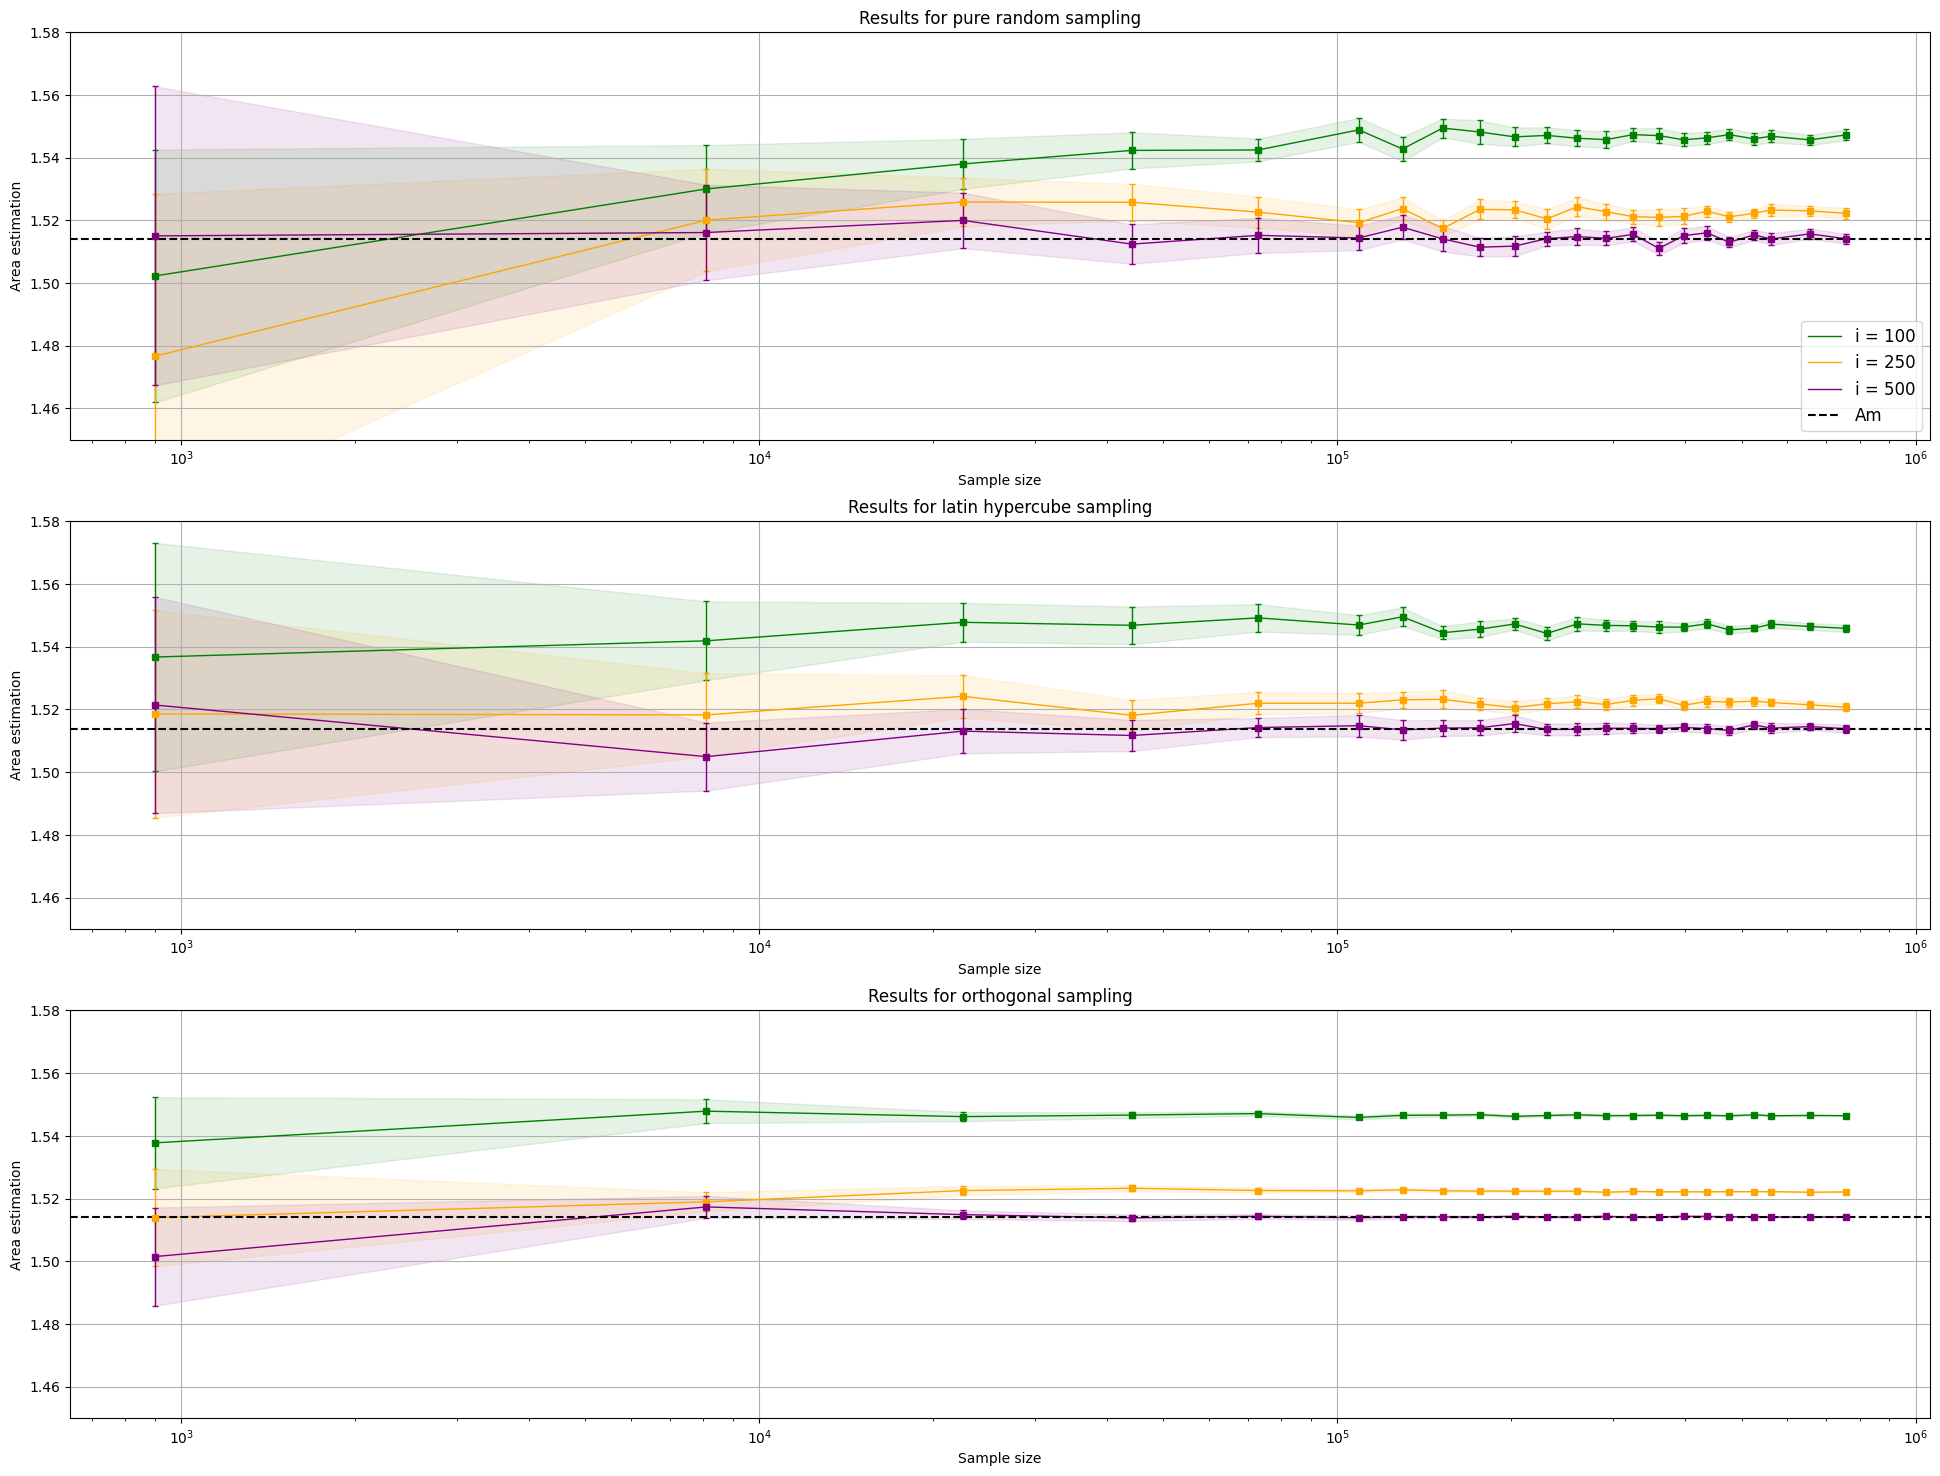

In [340]:
""""
Plots
"""

# initialize plots
fig, axs = plt.subplots(3,1,figsize=(24,18))

# colors for lines
colors = ["green", "orange", "purple"]

# loop over all results
for i, (sample_type, data) in enumerate(results_by_sample_type.items()):
    # results of one sample type

    Am = [Am_by_sample_type[sample_type]]

    for j, current_iteration in enumerate(n_it):
        means = []
        lower_bounds = []
        upper_bounds = []

        # loop through tuples in data
        for iteration, n_sample, mean, lower_bound, upper_bound in data:

            if current_iteration == iteration:
                means.append(mean)
                lower_bounds.append(lower_bound)
                upper_bounds.append(upper_bound)
                
        # plots 
        if means:
            # error bars
            confidence = [np.array(means) - np.array(lower_bounds), np.array(upper_bounds) - np.array(means)]
            axs[i].errorbar(n_samples, means, yerr=confidence, fmt="s", color=colors[j], capsize=2, markersize=4, elinewidth=1)
            # lines
            axs[i].plot(n_samples, means, label = f"i = {current_iteration}", color=colors[j], linewidth=1)
            axs[i].fill_between(n_samples, lower_bounds, upper_bounds, alpha=0.1, color=colors[j])

    axs[i].axhline(y=Am, label="Am", linestyle="--", color="black")
    
    axs[i].set_title(f"Results for {sample_type} sampling")
    if sample_type == "pure_random":
            axs[i].set_title(f"Results for pure random sampling")
    if sample_type == "lhs":
        axs[i].set_title(f"Results for latin hypercube sampling")
    axs[i].set_ylabel("Area estimation")
    axs[i].set_xscale('log')
    axs[i].set_xlabel("Sample size")
    if i == 0:
        axs[i].legend(fontsize="large")
    axs[i].grid()
    axs[i].set_ylim(1.45, 1.58)


plt.savefig("estimations", dpi = 300)

## Statistical testing 

Testing between sample types 

T-test: pure_random vs lhs:
T-statistic: 0.2622477903879923
p-value: 0.7937009835503525
Fail to reject H0. Means are not significantly different.


F-test: pure_random vs lhs:
F-statistic: 0.06877390356319474
p-value: 0.7936808727939395
Fail to reject H0. Variances are not significantly different.


T-test: pure_random vs orthogonal:
T-statistic: -0.10395777369720469
p-value: 0.9176203295709437
Fail to reject H0. Means are not significantly different.


F-test: pure_random vs orthogonal:
F-statistic: 0.010807218712062664
p-value: 0.9174153137391632
Fail to reject H0. Variances are not significantly different.


T-test: lhs vs orthogonal:
T-statistic: -0.5358517098144261
p-value: 0.5944278476445701
Fail to reject H0. Means are not significantly different.


F-test: lhs vs orthogonal:
F-statistic: 0.2871370549103351
p-value: 0.5932751491809392
Fail to reject H0. Variances are not significantly different.




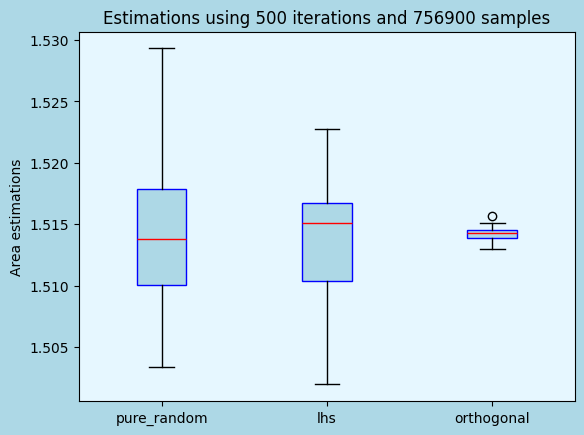

In [315]:


n_it_chosen = 500
n_samples_chosen = 756900

boxplot_data = {}

for sample_type in sample_types: 
    file_path = f"main_results/{sample_type}_with_{n_it_chosen}_iterations_and_{n_samples_chosen}_samples.pkl"
    with open(file_path, "rb") as f: 
        results = [] 
        while True: 
            try:
                results.append(pickle.load(f))
            except EOFError:
                break

    if isinstance(results[0], float):
        flat_results = results
    else:
        flat_results = [item for sublist in results for item in sublist]

    boxplot_data[sample_type] = flat_results

fig, ax = plt.subplots()
ax.set_facecolor("#e6f7ff")  
fig.set_facecolor("lightblue")

ax.boxplot(
    boxplot_data.values(), 
    labels=boxplot_data.keys(),
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="blue"), 
    medianprops=dict(color="red")
)

ax.set_title(f"Estimations using {n_it_chosen} iterations and {n_samples_chosen} samples")
ax.set_ylabel("Area estimations")

#T-test between sampling methods 
for i in range(len(sample_types)):
    for j in range(i + 1, len(sample_types)):
        group1 = boxplot_data[sample_types[i]]
        group2 = boxplot_data[sample_types[j]]
        alpha = 0.05        

        
        t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
         
        print(f"T-test: {sample_types[i]} vs {sample_types[j]}:")
        print("T-statistic:", t_stat)
        print("p-value:", p_value)
        
        if p_value < alpha:
            print("Reject H0. Means are significantly different.")
        else:
            print("Fail to reject H0. Means are not significantly different.")
        print("\n")
        
        f_stat, f_p_value = f_oneway(group1, group2)
        print(f"F-test: {sample_types[i]} vs {sample_types[j]}:")
        print("F-statistic:", f_stat)
        print("p-value:", f_p_value)

        if f_p_value < alpha:
            print("Reject H0. Variances are significantly different.")
        else:
            print("Fail to reject H0. Variances are not significantly different.")
        print("\n")
        




testing between number of iterations

In [269]:
n_samples_chosen = 756900
iteration_values = [100, 250, 500]  # Iteration values to compare

boxplot_data = {}

for sample_type in sample_types: 
    boxplot_data[sample_type] = {}
    for n_it in iteration_values:
        file_path = f"main_results/{sample_type}_with_{n_it}_iterations_and_{n_samples_chosen}_samples.pkl"
        with open(file_path, "rb") as f: 
            results = [] 
            while True: 
                try:
                    results.append(pickle.load(f))
                except EOFError:
                    break

        if isinstance(results[0], float):
            flat_results = results
        else:
            flat_results = [item for sublist in results for item in sublist]

        boxplot_data[sample_type][n_it] = flat_results

for sample_type in sample_types:
    print(f"T-tests for sampling method: {sample_type}")
    for i in range(len(iteration_values)):
        for j in range(i + 1, len(iteration_values)):
            n_it_1 = iteration_values[i]
            n_it_2 = iteration_values[j]
            group1 = boxplot_data[sample_type][n_it_1]
            group2 = boxplot_data[sample_type][n_it_2]

            t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
            print(f"T-test: {n_it_1} iterations vs {n_it_2} iterations for {sample_type}:")
            print("T-statistic:", t_stat)
            print("p-value:", p_value)

            alpha = 0.05
            if p_value < alpha:
                print("Reject H0. Means are significantly different.")
            else:
                print("Fail to reject H0. Means are not significantly different.")
            print("\n")


T-tests for sampling method: pure_random
T-test: 100 iterations vs 250 iterations for pure_random:
T-statistic: 20.438090787515417
p-value: 4.129696461752009e-37
Reject H0. Means are significantly different.


T-test: 100 iterations vs 500 iterations for pure_random:
T-statistic: 28.330575376338228
p-value: 1.2214472561755596e-48
Reject H0. Means are significantly different.


T-test: 250 iterations vs 500 iterations for pure_random:
T-statistic: 6.982727369923287
p-value: 3.6148033155190617e-10
Reject H0. Means are significantly different.


T-tests for sampling method: lhs
T-test: 100 iterations vs 250 iterations for lhs:
T-statistic: 29.474257091499762
p-value: 3.1242770458047976e-50
Reject H0. Means are significantly different.


T-test: 100 iterations vs 500 iterations for lhs:
T-statistic: 37.22778592107586
p-value: 3.5549217757085556e-59
Reject H0. Means are significantly different.


T-test: 250 iterations vs 500 iterations for lhs:
T-statistic: 7.621201362632502
p-value: 1.617

Testing between 900 and 756900 iterations 

In [270]:
n_samples_small = 900
n_samples_large = 756900
iteration_values = [100, 250, 500]  
lowest_value = 100
boxplot_data = {}

for sample_type in sample_types:
    print(f"F-tests for sampling method: {sample_type}")
    for n_it in iteration_values:
        file_path_small = f"main_results/{sample_type}_with_{n_it}_iterations_and_{n_samples_small}_samples.pkl"
        file_path_large = f"main_results/{sample_type}_with_{n_it}_iterations_and_{n_samples_large}_samples.pkl"
        
        with open(file_path_small, "rb") as f_small, open(file_path_large, "rb") as f_large:
            results_small = []
            results_large = []
            
            while True:
                try:
                    results_small.append(pickle.load(f_small))
                except EOFError:
                    break
            
            while True:
                try:
                    results_large.append(pickle.load(f_large))
                except EOFError:
                    break

        flat_small = results_small if isinstance(results_small[0], float) else [item for sublist in results_small for item in sublist]
        flat_large = results_large if isinstance(results_large[0], float) else [item for sublist in results_large for item in sublist]
        
        f_stat, f_p_value = f_oneway(flat_small, flat_large)
      


        print(f"F-test: {n_samples_small} samples vs {n_samples_large} samples for {sample_type} at {n_it} iterations:")
        print("F-statistic:", f_stat)
        print("p-value:", p_value)

        alpha = 0.05
        if p_value < alpha:
            print("Reject H0. Variances are significantly different.")
        else:
            print("Fail to reject H0. Variances are not significantly different.")
        print("\n")

F-tests for sampling method: pure_random
F-test: 900 samples vs 756900 samples for pure_random at 100 iterations:
F-statistic: 5.01424748700871
p-value: 1.7339359379443573e-88
Reject H0. Variances are significantly different.


F-test: 900 samples vs 756900 samples for pure_random at 250 iterations:
F-statistic: 3.125881307004038
p-value: 1.7339359379443573e-88
Reject H0. Variances are significantly different.


F-test: 900 samples vs 756900 samples for pure_random at 500 iterations:
F-statistic: 0.0014266149615551377
p-value: 1.7339359379443573e-88
Reject H0. Variances are significantly different.


F-tests for sampling method: lhs
F-test: 900 samples vs 756900 samples for lhs at 100 iterations:
F-statistic: 0.25496673009575727
p-value: 1.7339359379443573e-88
Reject H0. Variances are significantly different.


F-test: 900 samples vs 756900 samples for lhs at 250 iterations:
F-statistic: 0.016913738181265264
p-value: 1.7339359379443573e-88
Reject H0. Variances are significantly differe

In [271]:
n_samples_chosen = 900
n_it = [100,250,500]


for sample_type in sample_types:
    print(f"T-tests for {sample_type} \n ".upper() )
    file_Am = f"main_results/{sample_type}_Am.pkl"
    with open(file_Am, "rb") as f_Am:
        results_Am = []
        while True:
            try:
                results_Am.append(pickle.load(f_Am))
            except EOFError:
                break

    flat_results_Am = (
        results_Am if isinstance(results_Am[0], float) else [item for sublist in results_Am for item in sublist]
    )

    for iteration in n_it:
        file_path = f"main_results/{sample_type}_with_{iteration}_iterations_and_{n_samples_chosen}_samples.pkl"
        with open(file_path, "rb") as f_iter:
            results_iter = []
            while True:
                try:
                    results_iter.append(pickle.load(f_iter))
                except EOFError:
                    break

        flat_results_iter = (
            results_iter if isinstance(results_iter[0], float) else [item for sublist in results_iter for item in sublist]
        )

        t_stat, p_value = ttest_ind(flat_results_iter, flat_results_Am)

        print(f"T-test: {sample_type} with {iteration} iterations vs Am:")
        print(f"  T-statistic: {t_stat:.4f}, p-value: {p_value:.4e}")
        if p_value < alpha:
            print("  Result: Reject H0 (significant difference).")
        else:
            print("  Result: Fail to reject H0 (no significant difference).")
        print()








T-TESTS FOR PURE_RANDOM 
 
T-test: pure_random with 100 iterations vs Am:
  T-statistic: -0.4161, p-value: 6.7822e-01
  Result: Fail to reject H0 (no significant difference).

T-test: pure_random with 250 iterations vs Am:
  T-statistic: -1.3171, p-value: 1.9086e-01
  Result: Fail to reject H0 (no significant difference).

T-test: pure_random with 500 iterations vs Am:
  T-statistic: 0.1872, p-value: 8.5189e-01
  Result: Fail to reject H0 (no significant difference).

T-TESTS FOR LHS 
 
T-test: lhs with 100 iterations vs Am:
  T-statistic: 1.4367, p-value: 1.5400e-01
  Result: Fail to reject H0 (no significant difference).

T-test: lhs with 250 iterations vs Am:
  T-statistic: 0.4819, p-value: 6.3098e-01
  Result: Fail to reject H0 (no significant difference).

T-test: lhs with 500 iterations vs Am:
  T-statistic: 0.6277, p-value: 5.3166e-01
  Result: Fail to reject H0 (no significant difference).

T-TESTS FOR ORTHOGONAL 
 
T-test: orthogonal with 100 iterations vs Am:
  T-statistic: 3

Comparing Am to estimates 

In [313]:
from scipy.stats import ttest_ind
import pickle
import numpy as np

n_samples = [900, 756900]
n_it = 

for sample_size in n_samples:
    print(f"Statistical tests for error comparison at {sample_size} samples:")
    
    errors_by_method = {}
    mean_errors_by_method = {}
    
    for sample_type in sample_types:
        errors = []
        with open(f"main_results/{sample_type}_Am.pkl", "rb") as f_Am:
            Am_values = pickle.load(f_Am)  
            Am_mean = np.mean(Am_values)  
        
    
        results = []
        with open(f"main_results/{sample_type}_with_{n_it}_iterations_and_{sample_size}_samples.pkl", "rb") as f_results:
            try:
                while True:
                    result = pickle.load(f_results)
                    results.append(result)
            # end of file 
            except EOFError: 
                pass  
            
            errors.extend([abs(value - Am_mean) for value in results])  

        errors_by_method[sample_type] = errors
        mean_errors_by_method[sample_type] = np.mean(errors)

    print(f"Mean errors for each sampling method at {sample_size} samples and {n_it} iterations:")
    for sample_type in mean_errors_by_method:
        print(f"{sample_type}: {mean_errors_by_method[sample_type]}")
    print("\n")
    # Perform ttest
    sample_types_list = list(errors_by_method.keys())
    print("Pairwise t-tests:")

    for i in range(len(sample_types_list)):
        for j in range(i + 1, len(sample_types_list)):
            group1 = errors_by_method[sample_types_list[i]]
            group2 = errors_by_method[sample_types_list[j]]
            t_stat, p_val = ttest_ind(group1, group2)
            print(f"t-test between {sample_types_list[i]} and {sample_types_list[j]}:")
            print("T-statistic:", t_stat)
            print("p-value:", p_val)
            if p_val < 0.05:
                print(f" difference is significant \n")
            else:
                print(f" difference is insignificant\n")


Statistical tests for error comparison at 900 samples:
Mean errors for each sampling method at 900 samples and 100 iterations:
pure_random: 0.11062038186666667
lhs: 0.10460825031111114
orthogonal: 0.04838111573333331


Pairwise t-tests:
t-test between pure_random and lhs:
T-statistic: 0.3631865207573695
p-value: 0.717247774930301
 difference is insignificant

t-test between pure_random and orthogonal:
T-statistic: 4.710871181805914
p-value: 8.14196667449128e-06
 difference is significant 

t-test between lhs and orthogonal:
T-statistic: 4.758987029379588
p-value: 6.713329586515073e-06
 difference is significant 

Statistical tests for error comparison at 756900 samples:
Mean errors for each sampling method at 756900 samples and 100 iterations:
pure_random: 0.0366275702681991
lhs: 0.035231502349055324
orthogonal: 0.03613393033690044


Pairwise t-tests:
t-test between pure_random and lhs:
T-statistic: 1.3386070128178038
p-value: 0.18379579546680364
 difference is insignificant

t-test be

Comparing Am to $A_{i,s_{max}}$ 

In [322]:

sample_type = "pure_random"  
iterations = 500 
samples = 756900
file_path = f"main_results/{sample_type}_with_{iterations}_iterations_and_{samples}_samples.pkl"
with open(file_path, "rb") as f:
    results_iter = []
    while True:
        try:
            results_iter.append(pickle.load(f))
        except EOFError:
            break

file_Am = f"main_results/{sample_type}_Am.pkl"
with open(file_Am, "rb") as f_Am:
    results_Am = []
    while True:
        try:
            results_Am.append(pickle.load(f_Am))
        except EOFError:
            break

flat_results_Am = results_Am if isinstance(results_Am[0], float) else [item for sublist in results_Am for item in sublist]

# Perform the t-test
t_stat, p_value = ttest_ind(flat_results_iter, flat_results_Am)

print(f"T-test: {sample_type} with 500 iterations and 756900 samples vs Am:")
print(f"  T-statistic: {t_stat:.4f}, p-value: {p_value:.4e}")
if p_value < 0.05:
    print("  Result: Reject H0 (significant difference).")
else:
    print("  Result: Fail to reject H0 (no significant difference).")

T-test: pure_random with 500 iterations and 756900 samples vs Am:
  T-statistic: 5.5057, p-value: 2.9533e-07
  Result: Reject H0 (significant difference).


# Altered sampling methods that include antithetic variates

In [7]:
def monte_carlo_antithetic(n_samples, method, n_iterations, y_min, y_max, x_min, x_max, antithetic=False): 
    """
    Calculating the area of the mandelbrot set with the Monte Carlo approach.
    Samples are generated based on sample method and antithetic (true/false).
    """
    
    true_count = 0      


    if antithetic:
        if method == "lhs": 
            points = lhs_antithetic(n_samples, y_min, y_max, x_min, x_max)
        elif method == "orthogonal":
            points = orthogonal_antithetic(n_samples, x_min, x_max, y_min, y_max)
        elif method == "pure_random": 
            points = antithetic_random_samples(n_samples, y_min, y_max, x_min, x_max)
    else:
        if method == "lhs": 
            points = lhs_qmc(n_samples, y_min, y_max, x_min, x_max)
        elif method == "orthogonal":
            points = orthogonal_sample(n_samples, x_min, x_max, y_min, y_max)
        elif method == "pure_random": 
            points = pure_radom_sample(y_min, y_max, x_min, x_max, n_samples)


    for _, _, complex_element in points:
        if mandel_check(complex_element, n_iterations):
            true_count +=1 

    area_total = (x_max-x_min)*(y_max-y_min)
    mandel_area = (true_count/(len(points))) * area_total
    return mandel_area

def antithetic_random_samples(n_samples, x_min, x_max, y_min, y_max):
    """
    Adapted the 'pure random sample' function to incorporate antithetic variates
    """

    
    samples = []

    for i in range(n_samples): 
        x_coordinate = rd.uniform(x_min, x_max)
        y_coordinate  = rd.uniform(y_min, y_max)
        complex_element = complex(x_coordinate,y_coordinate)
        samples.append([x_coordinate, y_coordinate, complex_element])

        # initialize mirrorred samples
        x_antithetic = x_min + x_max - x_coordinate
        y_antithetic = y_min + y_max - y_coordinate

        complex_antithetic = complex(x_antithetic, y_antithetic)
        samples.append([x_antithetic, y_antithetic, complex_antithetic])
        
    return samples

    

def lhs_antithetic(n_samples, y_min, y_max, x_min, x_max):
    """
    Adapted the 'lhs qmc' function to incorporate antithetic variates
    """
    
    sampler = qmc.LatinHypercube(d=2)  

    # generate  samples
    lhs_samples = sampler.random(n=n_samples)

    # Rescale 
    x_coordinates_rescaled = x_min + (x_max - x_min) * lhs_samples[:, 0]
    y_coordinates_rescaled = y_min + (y_max - y_min) * lhs_samples[:, 1]

    # Initialize mirrorred samples
    x_antithetic = x_min + x_max - x_coordinates_rescaled
    y_antithetic = y_min + y_max - y_coordinates_rescaled

    x_combined = np.concatenate((x_coordinates_rescaled, x_antithetic))
    y_combined = np.concatenate((y_coordinates_rescaled, y_antithetic))

    complex_elements_combined = x_combined +  1j * y_combined

    # Combine
    points_combined = np.column_stack((x_combined, y_combined, complex_elements_combined))
    
    return points_combined.tolist()

def orthogonal_antithetic(n_samples, x_min, x_max, y_min, y_max): 
    """
    Adapted the 'orthogonal sampling' function to incorporate antithetic variates
    """

    blocks = int(np.sqrt(n_samples))
    samples = [] 

    # create two squares
    xlist = np.arange(0,blocks*blocks).reshape(blocks,blocks)
    ylist = np.arange(0,blocks*blocks).reshape(blocks,blocks)
    np.random.shuffle(xlist)
    np.random.shuffle(ylist)
    
    # scale and create random
    for i in range(blocks):
        for j in range(blocks):
            x_coordinate = x_min +  ((x_max-x_min) / n_samples) * (xlist[i][j] + np.random.random())
            y_coordinate = y_min + ((y_max-y_min) / n_samples) * (ylist[i][j] + np.random.random())
            complex_element = complex(x_coordinate, y_coordinate)
            samples.append([x_coordinate, y_coordinate, complex_element])

            # Initialize mirrorred samples
            x_antithetic = x_max + x_min - x_coordinate
            y_antithetic = y_max + y_min - y_coordinate

            complex_antithetic = complex(x_antithetic, y_antithetic)

            samples.append([x_antithetic, y_antithetic, complex_antithetic])


    return samples

def plot_antithetic_comparison(method, results, results_antithetic, n_samples, Am):
    """
    Plotting the comparison between a sampling method and their antithetic variant. 
    This function outputs one plot containing the mean estimate and the variance of both methods.
    """
    
    means_non_antithetic = []
    variances_non_antithetic = []
    means_antithetic = []
    variances_antithetic = []

    for n in n_samples:
        # Convert results to numpy arrays for processing
        non_antithetic = np.array(results[method][n])
        antithetic = np.array(results_antithetic[method][n])

        # Calculate means and variances for each sample size
        means_non_antithetic.append(np.mean(non_antithetic))
        variances_non_antithetic.append(np.var(non_antithetic))
        means_antithetic.append(np.mean(antithetic))
        variances_antithetic.append(np.var(antithetic))

    n_samples = np.array(n_samples)
    means_non_antithetic = np.array(means_non_antithetic)
    variances_non_antithetic = np.array(variances_non_antithetic)
    means_antithetic = np.array(means_antithetic)
    variances_antithetic = np.array(variances_antithetic)

    total_variance_non_antithetic = np.sum(variances_non_antithetic)
    total_variance_antithetic = np.sum(variances_antithetic)
    print(f"Total Variance for {method} (Non-Antithetic): {total_variance_non_antithetic}")
    print(f"Total Variance for {method} (Antithetic): {total_variance_antithetic}")


    # Create plot
    fig, ax1 = plt.subplots(figsize=(10, 8), dpi=300)

    ax1.plot(n_samples, means_non_antithetic, label=f"{method} (Non-Antithetic Mean)", linestyle="--", color="blue")
    ax1.plot(n_samples, means_antithetic, label=f"{method} (Antithetic Mean)", linestyle="-", color="orange")
    ax1.set_xscale("log")
    ax1.set_xlabel("Sample Size (log-scale)")
    ax1.set_ylabel("Mean Estimate", color="black")
    ax1.tick_params(axis="y", labelcolor="black")
    ax1.grid()

    ax1.fill_between(
        n_samples,
        means_non_antithetic - np.sqrt(variances_non_antithetic),
        means_non_antithetic + np.sqrt(variances_non_antithetic),
        alpha=0.2, color="blue", label=f"{method} (Non-Antithetic Variance)"
    )
    ax1.fill_between(
        n_samples,
        means_antithetic - np.sqrt(variances_antithetic),
        means_antithetic + np.sqrt(variances_antithetic),
        alpha=0.2, color="orange", label=f"{method} (Antithetic Variance)"
    )

    ax1.axhline(Am, linestyle="--", color="black", label="Am", linewidth=1.5)


    ax1.legend(loc="best")

    plt.title(f"Mean and Variance Comparison for {method}")

    plt.tight_layout()
    plt.show()


def statistical_tests(results, results_antithetic, sample_types, n_samples):
    """
    Function to perform t-test and f-test on the combined samples of a non-antithetic and antithetic method.
    """
    
    comparison_results = {}

    for method in sample_types:
        combined_non_antithetic = []
        combined_antithetic = []

        # Combine all samples for the method across n_samples
        for n in n_samples:
            combined_non_antithetic.extend(results[method][n])
            combined_antithetic.extend(results_antithetic[method][n])

        # Convert to numpy arrays
        combined_non_antithetic = np.array(combined_non_antithetic)
        combined_antithetic = np.array(combined_antithetic)
        # Perform t-test for means
        t_stat, t_p_value = ttest_ind(combined_non_antithetic, combined_antithetic, equal_var=False)

        # Perform Bartlett's test for variances
        bartlett_stat, bartlett_p_value = bartlett(combined_non_antithetic, combined_antithetic)

        # Store results
        comparison_results[method] = {
            "t-test (Means)": {"t-statistic": t_stat, "p-value": t_p_value},
            "Bartlett-test (Variances)": {"Bartlett-statistic": bartlett_stat, "p-value": bartlett_p_value}
        }

    return comparison_results

    

In [ ]:

n_runs = 50
samples = 10000
i = 1000000
iterations = 500
x_min, x_max = -2, 2
y_min, y_max = -2, 2
n_samples = [900, 8100, 10000, 12000, 14000, 16000, 18000, 20000, 30000]



sample_types =  ['pure_random', 'lhs', 'orthogonal']

results = {sample_type: {n: [] for n in n_samples} for sample_type in sample_types}
results_antithetic = {sample_type: {n: [] for n in n_samples} for sample_type in sample_types}

#Get mandelbrot area estimates for non-antithetic sampling methods
for sample_type in sample_types:
    for n in n_samples:
        for _ in tqdm(range(n_runs), desc=f"Running {sample_type} sampling (n={n})", leave=True):
            estimate = monte_carlo_antithetic(n, sample_type, iterations, y_min, y_max, x_min, x_max, antithetic=False)
            results[sample_type][n].append(estimate)


#Get mandelbrot area estimates for antithetic sampling methods
for sample_type in sample_types:
    for n in n_samples:
        for _ in tqdm(range(n_runs), desc=f"Running {sample_type} antithetic sampling (n={n})", leave=True):
            estimate = monte_carlo_antithetic(n, sample_type, iterations, y_min, y_max, x_min, x_max, antithetic=True)
            results_antithetic[sample_type][n].append(estimate)

with open("results_4_less_runs.pkl", "wb") as file:
    pickle.dump((results, results_antithetic), file)

Running pure_random antithetic sampling (n=8100): 100%|██████████| 50/50 [00:07<00:00,  6.45it/s]
Running pure_random antithetic sampling (n=10000): 100%|██████████| 50/50 [00:09<00:00,  5.19it/s]
Running pure_random antithetic sampling (n=12000): 100%|██████████| 50/50 [00:11<00:00,  4.34it/s]
Running pure_random antithetic sampling (n=14000): 100%|██████████| 50/50 [00:13<00:00,  3.72it/s]
Running pure_random antithetic sampling (n=16000): 100%|██████████| 50/50 [00:15<00:00,  3.25it/s]
Running pure_random antithetic sampling (n=18000): 100%|██████████| 50/50 [00:17<00:00,  2.82it/s]
Running pure_random antithetic sampling (n=20000): 100%|██████████| 50/50 [00:19<00:00,  2.61it/s]
Running pure_random antithetic sampling (n=30000): 100%|██████████| 50/50 [00:29<00:00,  1.72it/s]
Running orthogonal antithetic sampling (n=30000): 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


In [6]:
file_path = "results_4_less_runs.pkl"
sample_types =  ['pure_random', 'lhs', 'orthogonal']
with open(file_path, "rb") as file:
    while True:
        try:
            results, results_antithetic = pickle.load(file)
        except EOFError:
            # End of data file
            break

Am_by_sample_type = {}

for sample_type in sample_types:
    with open(f"main_results/{sample_type}_Am.pkl", "rb") as f:
        Am_results = pickle.load(f)  # Load Am results
        Am_mean = np.mean(Am_results)  # Compute the mean of Am
        Am_by_sample_type[sample_type] = Am_mean

print("Am values by sample type:", Am_by_sample_type)

Am values by sample type: {'pure_random': 1.5105785600000001, 'lhs': 1.51064288, 'orthogonal': 1.51031712}


Total Variance for pure_random (Non-Antithetic): 0.03500284401549963
Total Variance for pure_random (Antithetic): 0.022066752594332707


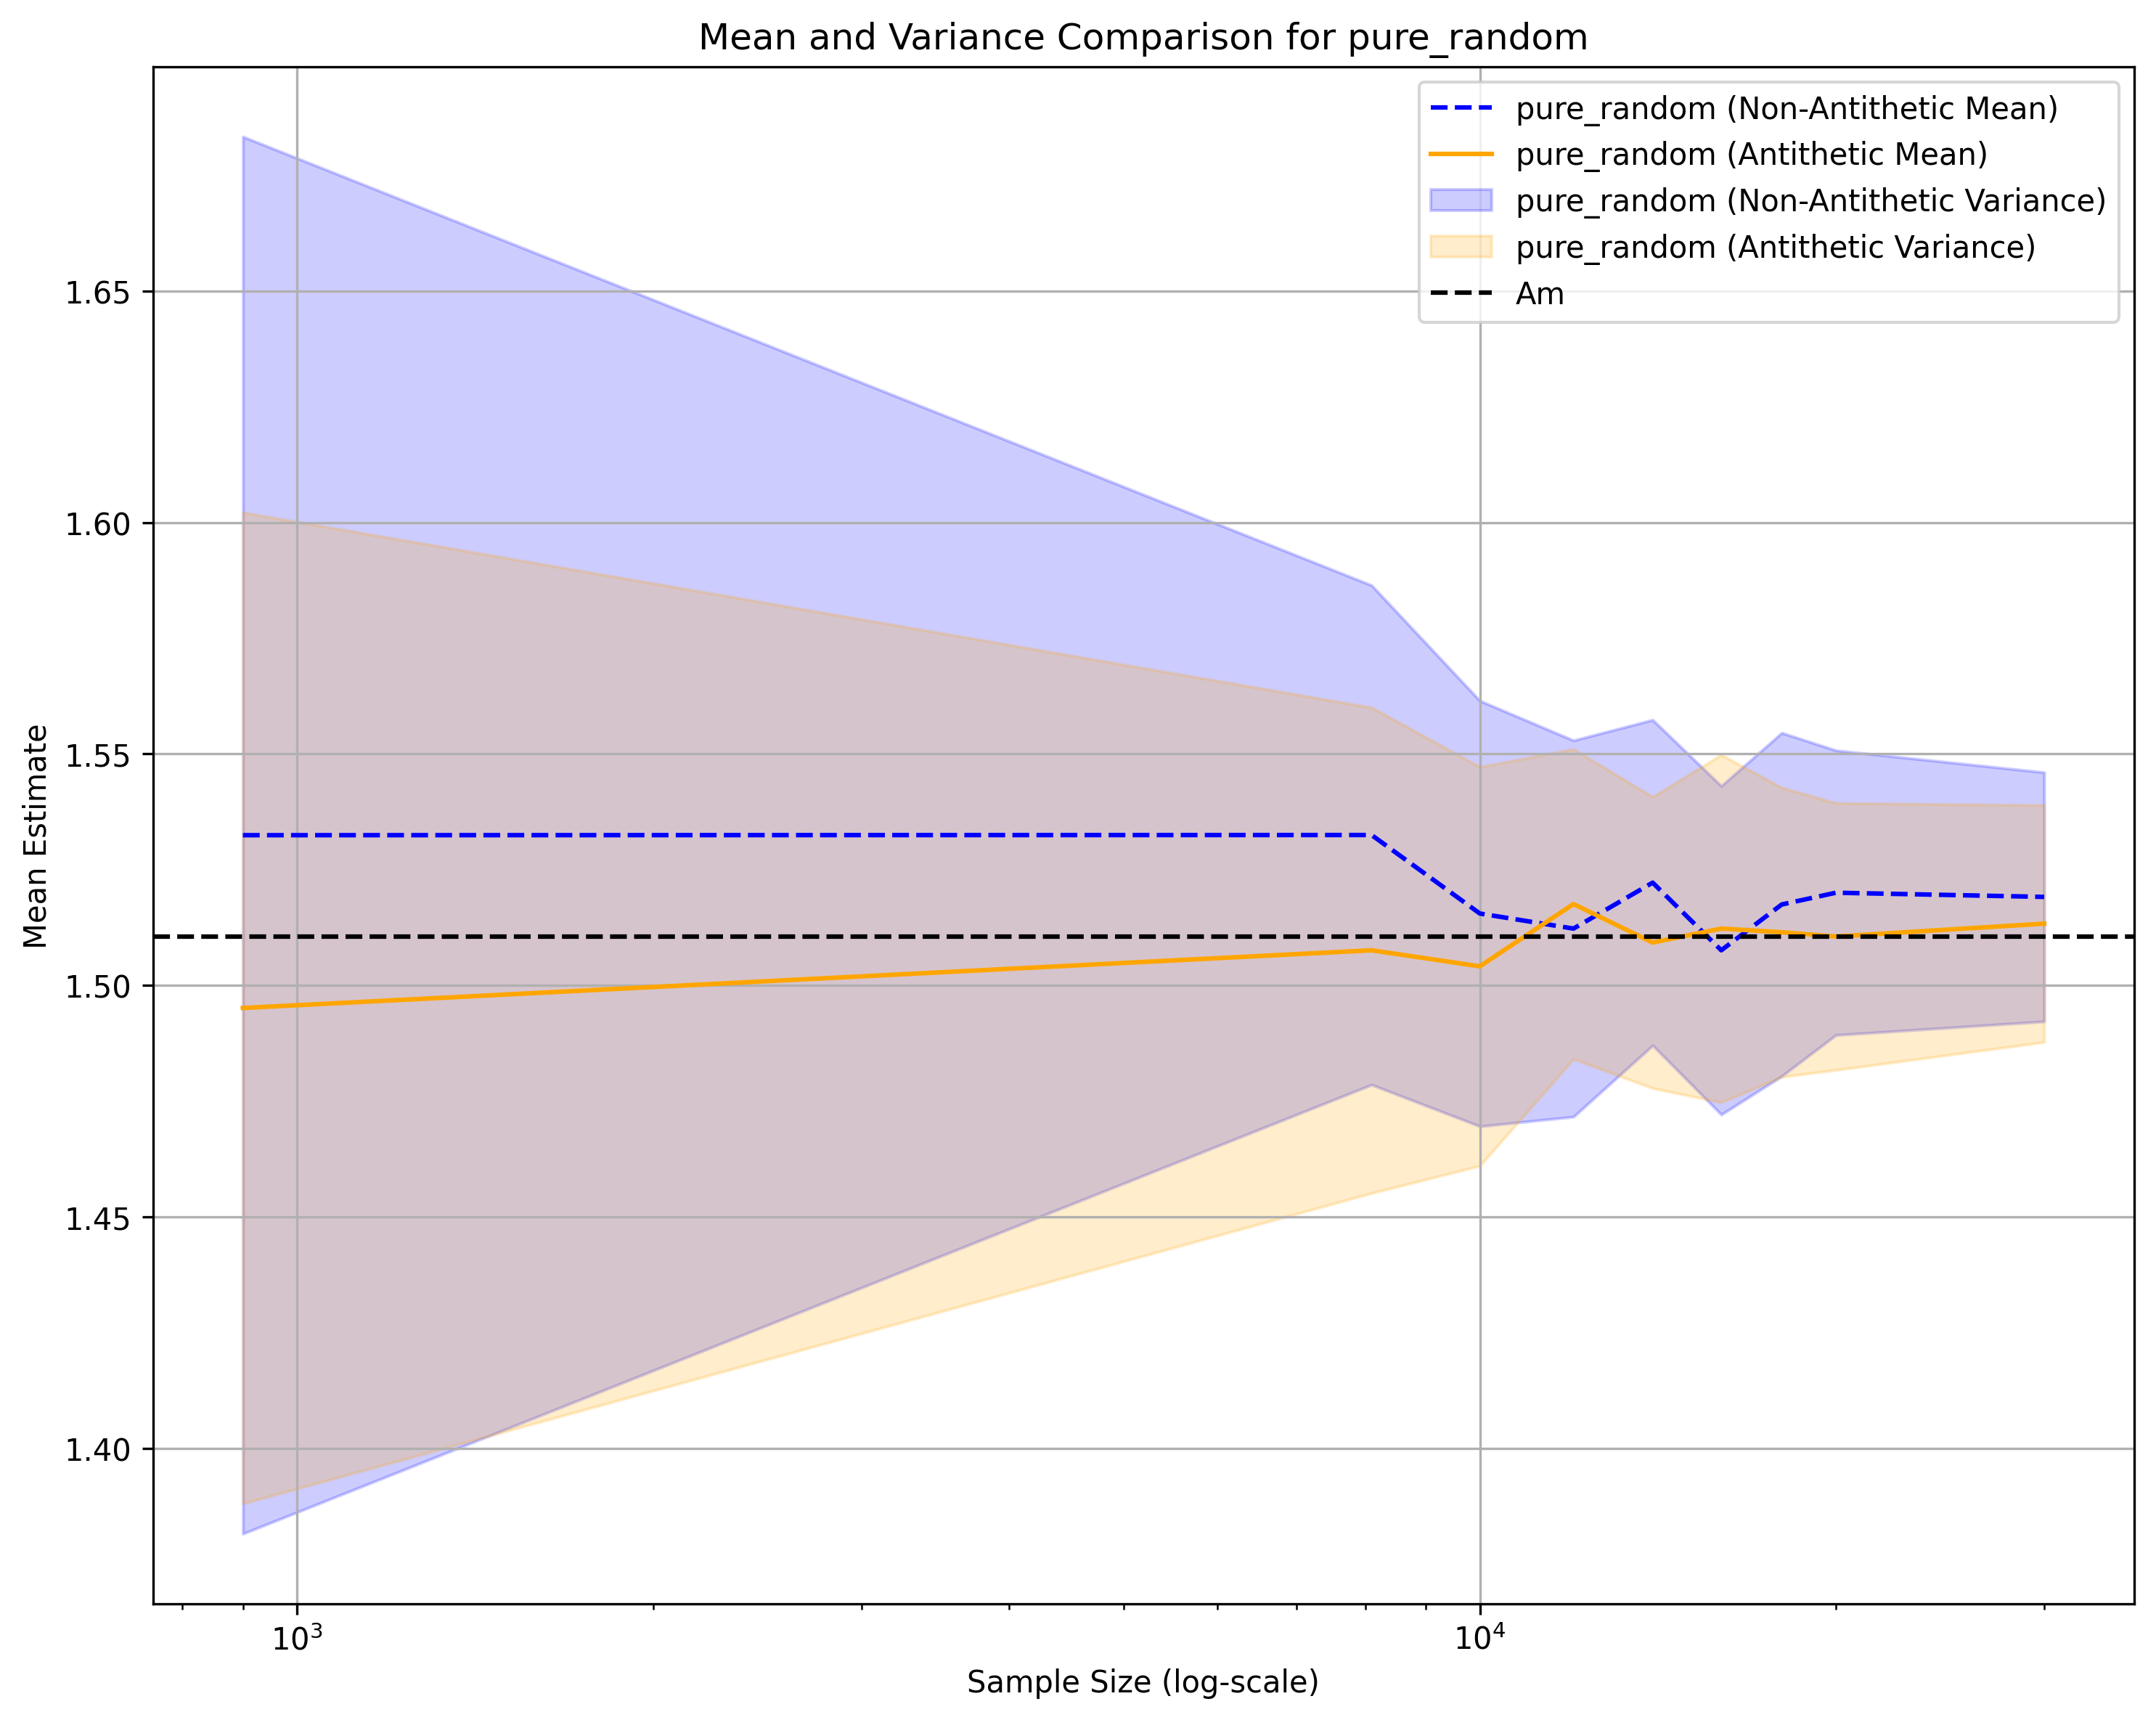

Total Variance for lhs (Non-Antithetic): 0.017142382931418496
Total Variance for lhs (Antithetic): 0.011590898666243639


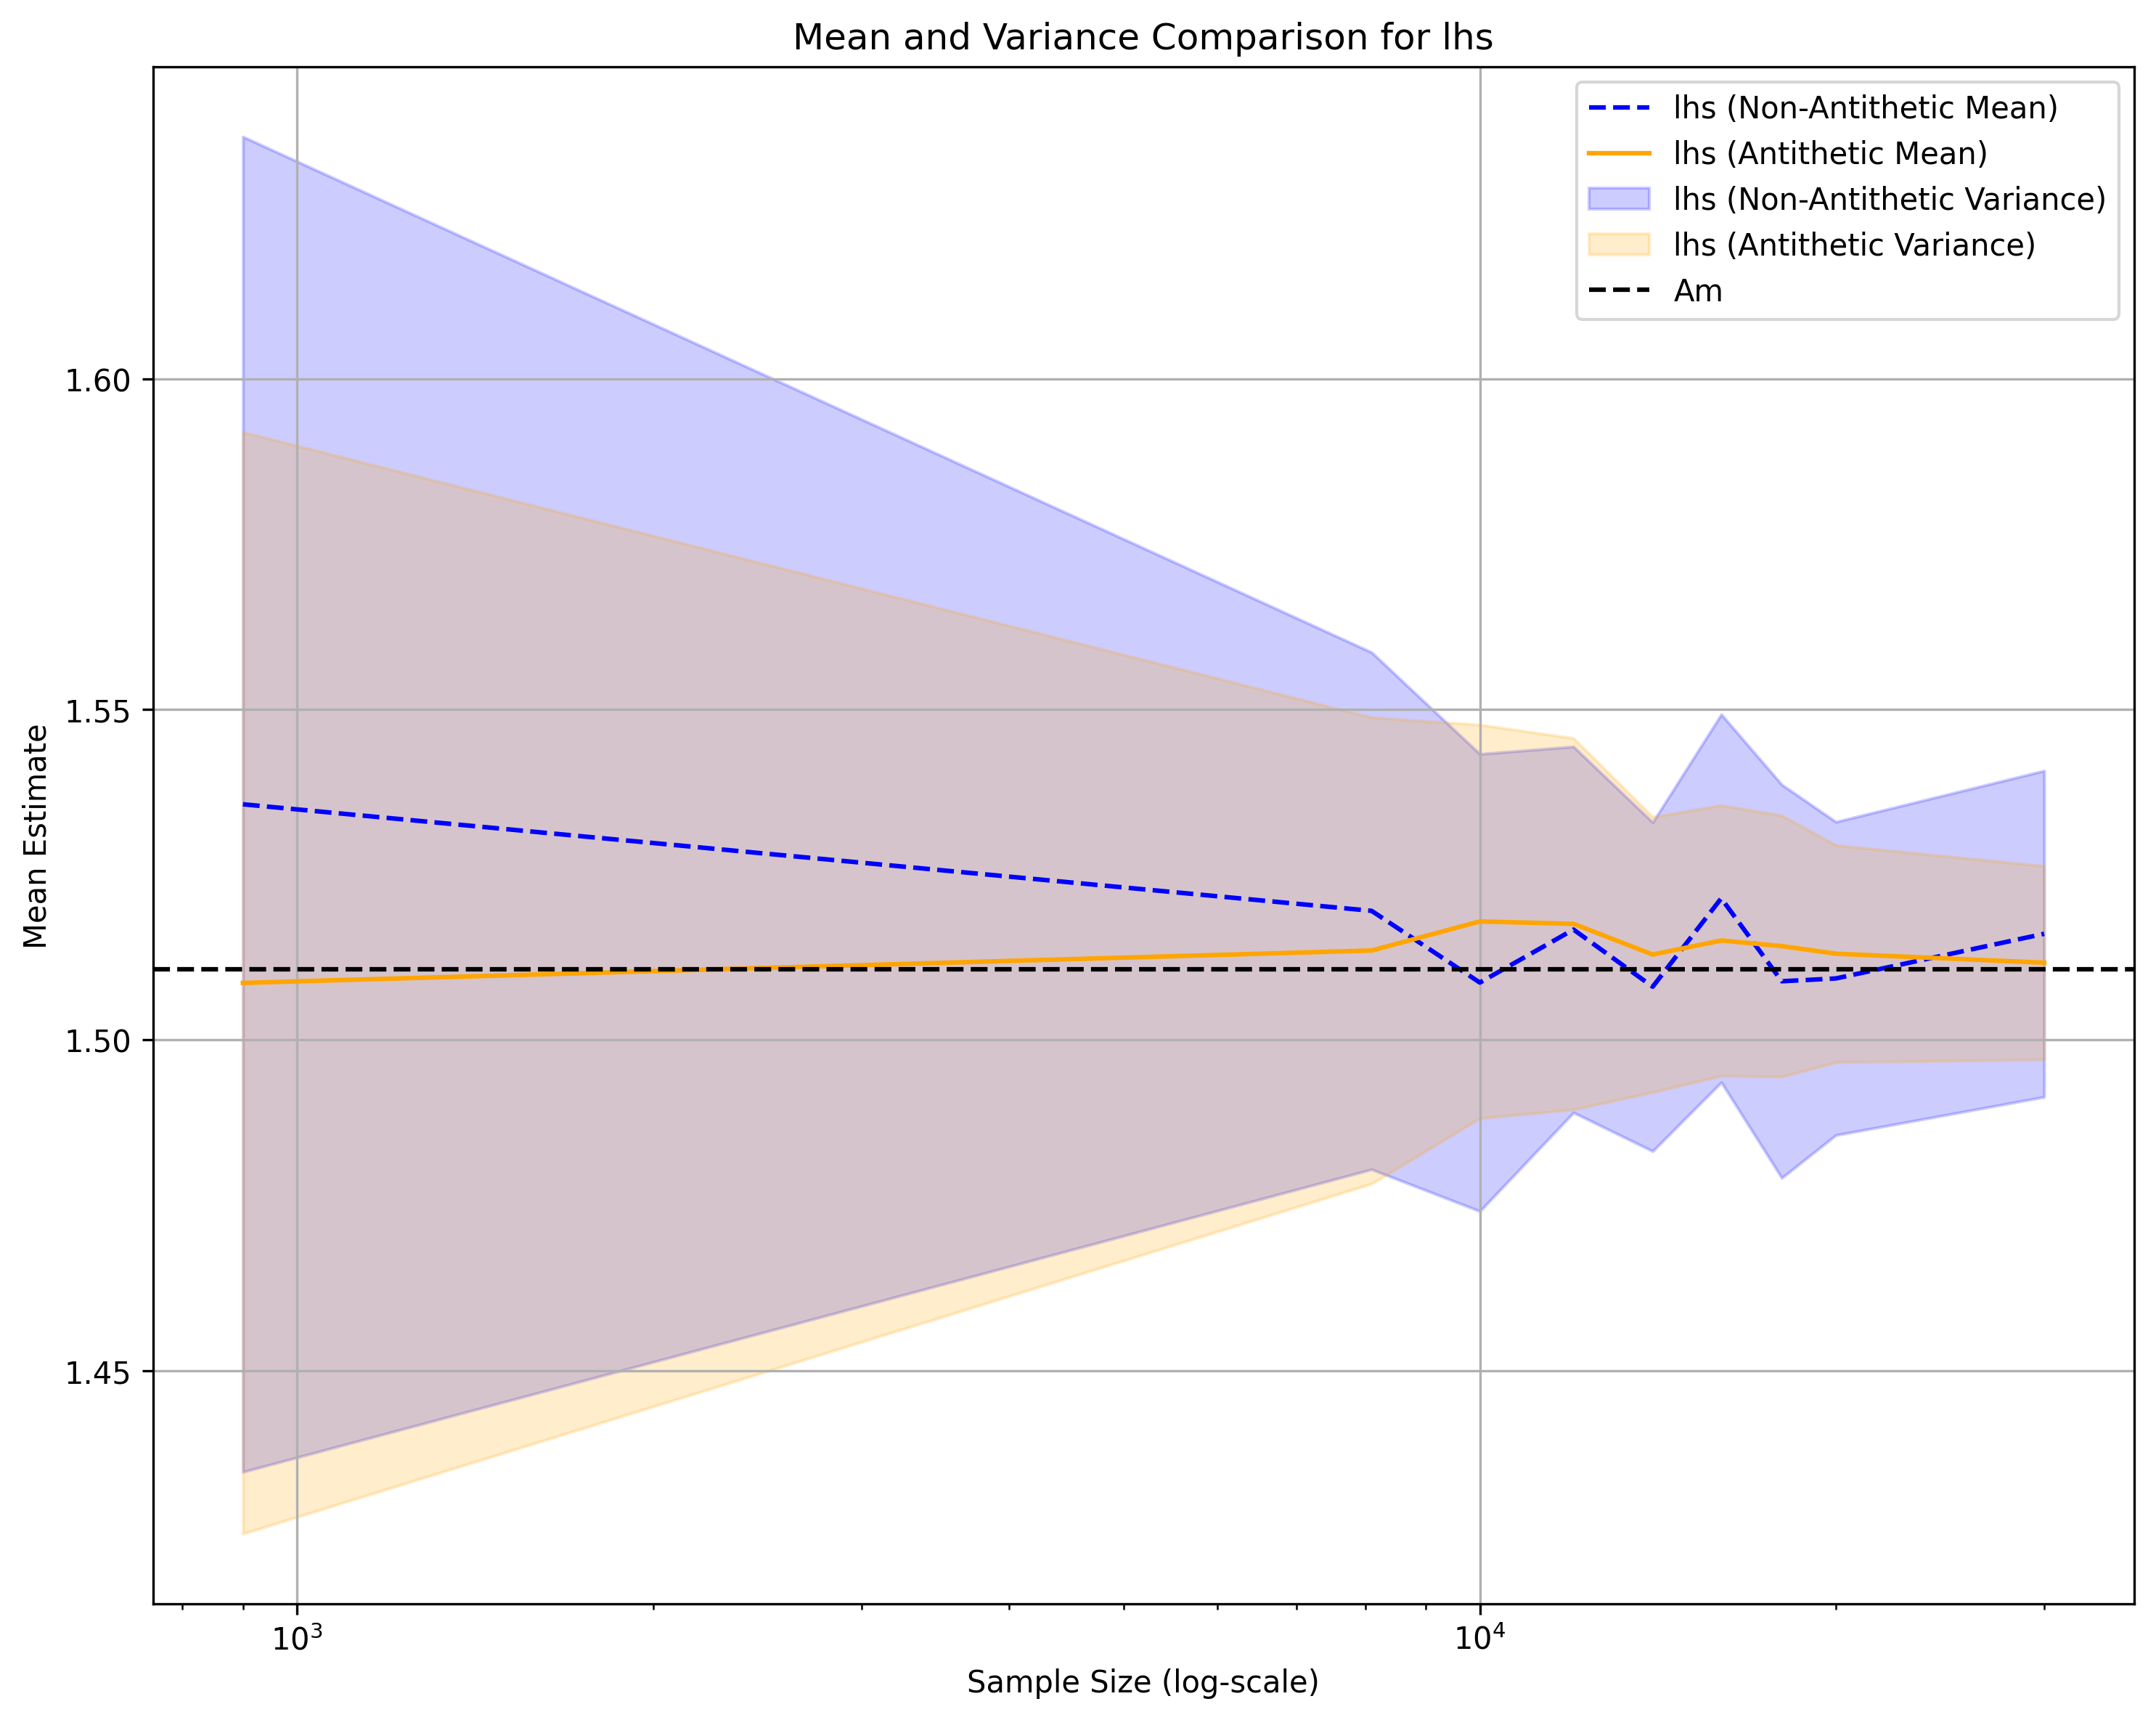

Total Variance for orthogonal (Non-Antithetic): 4.930380657631324e-31
Total Variance for orthogonal (Antithetic): 0.6372670747982796


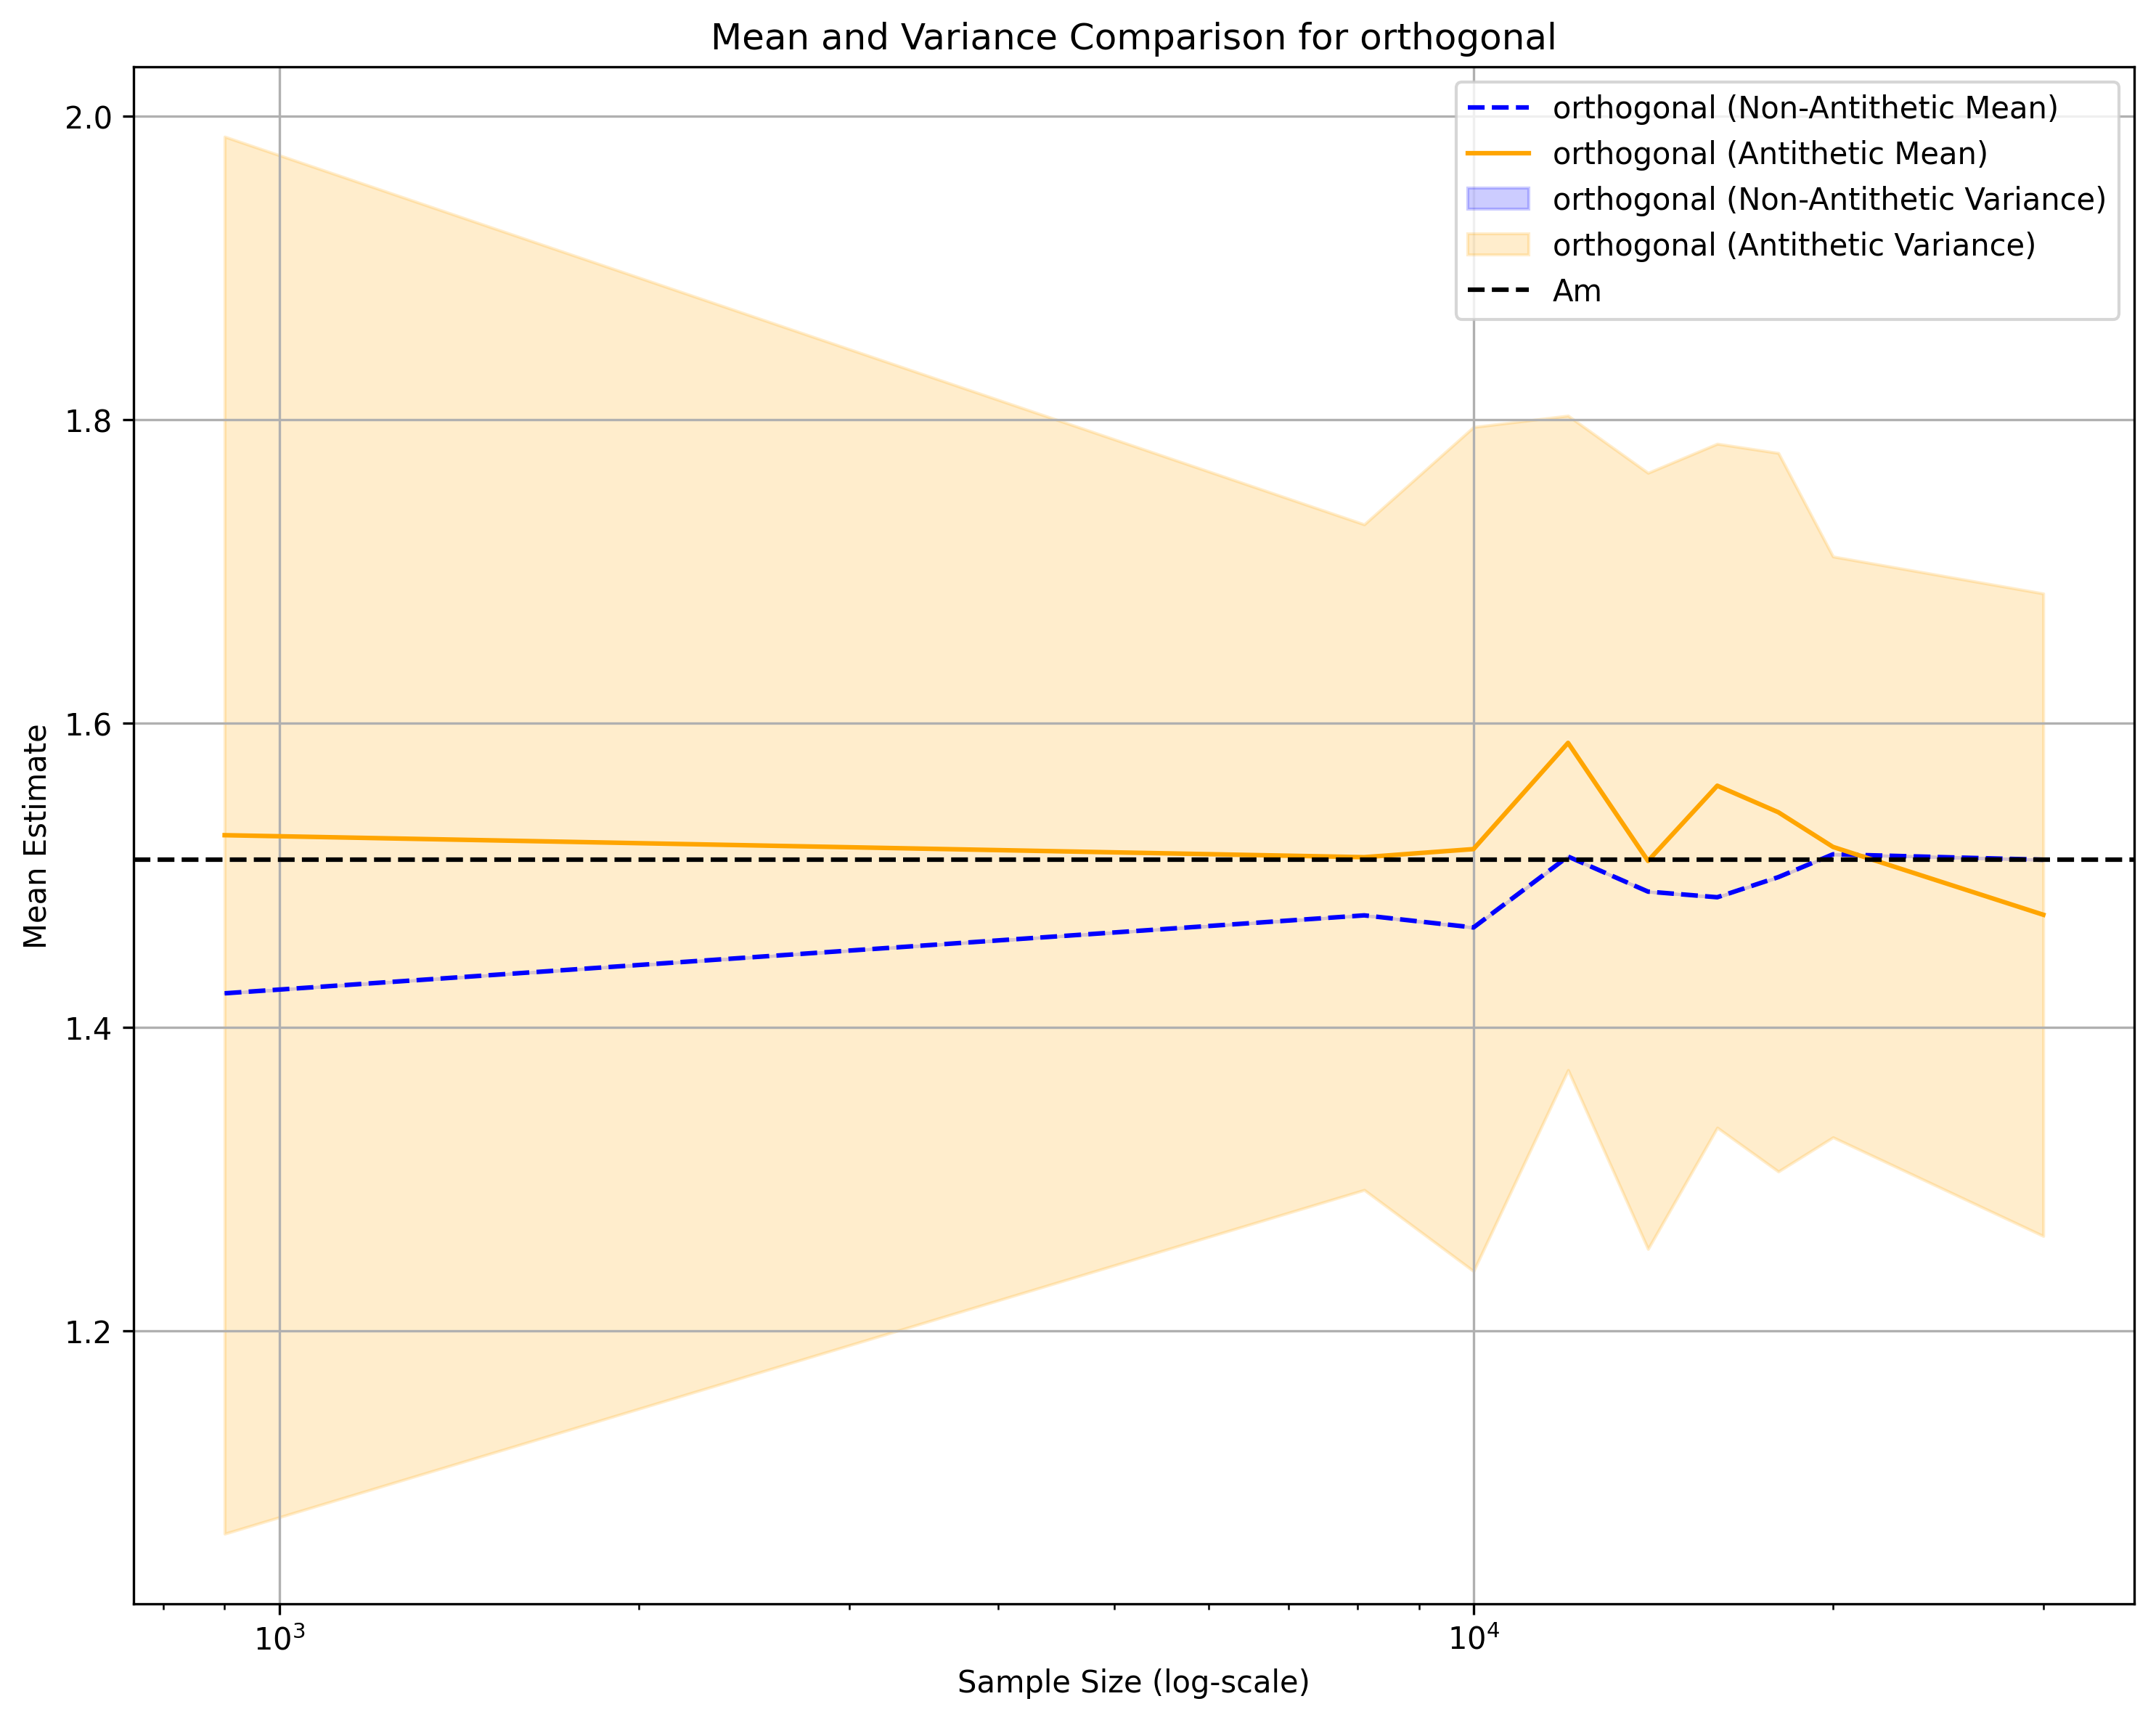

In [8]:
#All the plots are displayed with a dpi of 300 to get high-resolution plots.

n_samples = [900, 8100, 10000, 12000, 14000, 16000, 18000, 20000, 30000]

plot_antithetic_comparison("pure_random", results, results_antithetic, n_samples, Am_by_sample_type["pure_random"])

plot_antithetic_comparison("lhs", results, results_antithetic, n_samples, Am_by_sample_type["lhs"])

plot_antithetic_comparison("orthogonal", results, results_antithetic, n_samples, Am_by_sample_type["orthogonal"])

In [463]:
#Perform t-tests and print them

n_samples = [900, 8100, 10000, 12000, 14000, 16000, 18000, 20000, 30000]
sample_types = ['pure_random', 'lhs', 'orthogonal']

comparison_results = statistical_tests(results, results_antithetic, sample_types, n_samples)

for method in sample_types:
    print(f"Comparison for {method}:")
    print(f"  t-test (Means): {comparison_results[method]['t-test (Means)']}")
    print(f"  Bartlett-test (Variances): {comparison_results[method]['Bartlett-test (Variances)']}")

Comparison for pure_random:
  t-test (Means): {'t-statistic': 2.8707707991669196, 'p-value': 0.004195938023312102}
  Bartlett-test (Variances): {'Bartlett-statistic': 23.750685648126304, 'p-value': 1.0965630445219857e-06}
Comparison for lhs:
  t-test (Means): {'t-statistic': 0.812515153433626, 'p-value': 0.416720762851315}
  Bartlett-test (Variances): {'Bartlett-statistic': 19.858782501433062, 'p-value': 8.337878344753904e-06}
Comparison for orthogonal:
  t-test (Means): {'t-statistic': -3.2713292267347245, 'p-value': 0.0011511687811576984}
  Bartlett-test (Variances): {'Bartlett-statistic': 1425.6196472663655, 'p-value': 0.0}
